# SISTEMA DE PREDICCIÓN DE APROBACIÓN DE MATERIAS
# CARRERA TELEMÁTICA UNIVERSIDAD DE GUAYAQUIL

# 1: funciones requeridas para usar esta aplicación
python -m pip install --upgrade pip
python -m pip install tensorflow
python -m pip install Pillow
python -m pip install -U matplotlib
python -m pip install scipy
python -m pip install pandas
python -m pip install scikit-learn
python -m pip install openpyxl

In [16]:
# Librerías necesarias en el programa
import os
import pandas as pd
import numpy as np
import re
from cassandra.cluster import Cluster
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

# Funciones propias

In [17]:
# Se genera la condición de estado con "Aprobado" si un estudiante cumple con tener un promedio mayor o igual a 7.0 y Tener asistencia mayor o igual a 70% 
# para esto se usa una función definida con el nombre de CondicionAprobado que revisa las columnas necesarias y define si el estado es Aprobado o no

def CondicionAprobado(fila): # Definición de la función que asigna la condición del estado del estudiante x materia
    if fila["PROMEDIOS ASISTENCIA"]>69.9999 and fila["PROMEDIO FINAL"]>6.9999:
      cap=1
    else:
       cap=0
    return cap

# Preparar los datos para ser cargados en Cassandra
def convertird(dato,tipo):
    convertido=""
    if tipo == "text":
	    convertido=str("'" + str(dato) + "'")
    elif tipo == "int":
        convertido=str(dato)
    elif tipo == "date":
        convertido=str("'" + str(datetime.strftime(datetime.strptime(str(dato), '%d/%m/%Y %H:%M:%S'),'%Y-%m-%d')) + "'") 
    elif tipo == "bigint":
        convertido=str(dato)
    elif tipo == "float":
        convertido=str(dato)
    else:
        convertido=str("'" + str(dato) + "'")
    return convertido


# Subir datos a Cassandra

In [ ]:
# Ruta de datos=carpeta actual\\data\\calif : Aquí están los datos de los ciclos anteriores para el modelado
ArchiDirec=os.getcwd()+"\\data\\calif\\" 
# Obtener la lista de archivos en la carpeta
archivos = os.listdir(ArchiDirec)

# Conecta con el cluster de Cassandra
cluster = Cluster(['localhost'])
session = cluster.connect('dataug')
# Preparar la tabla en Cassandra
session.execute('''
   CREATE TABLE IF NOT EXISTS calificaciones (
   periodo TEXT, identificacion TEXT, nivel INT, cod_materia BIGINT, cod_tcalifica INT, docente TEXT, nota DOUBLE,
   PRIMARY KEY (periodo, identificacion, nivel, cod_materia, cod_tcalifica, docente))''')

for archivo in archivos:
    print(ArchiDirec + archivo)
    # Lee el archivo Excel
    df = pd.read_excel( ArchiDirec + archivo)
    # Insertar datos en Cassandra
    for index, row in df.iterrows():
        # Obtener los datos con el formato acorde a los campoe en cassandra
        tipoCal=row['COD_TCALIFICA']
        if (tipoCal==151615  or tipoCal== 151635 or tipoCal== 151625 or tipoCal== 151633):
            addrow =convertird(row['PERIODO'],"text")  + "," + convertird(row['IDENTIFICACION'],"text") + "," + convertird(re.search(r'\d+',row['GRUPO'][9:11]).group(),"int") \
                + "," + convertird(row['COD_MATERIA'],"bigint") + "," + convertird(row['COD_TCALIFICA'],"int") + "," + convertird(row['DOCENTE'],"text")[:10] + "'," + convertird(row['NOTA'],"float") 
            #print(addrow)
            session.execute('INSERT INTO calificaciones (periodo,identificacion, nivel, cod_materia, cod_tcalifica,docente,nota) VALUES (' + addrow +')')

# Ruta de datos=carpeta actual\\data\\califTest : Aquí están los datos del ciclo actual para la predicci{on
ArchiDirec=os.getcwd()+"\\data\\califTest\\" 
# Obtener la lista de archivos en la carpeta
archivos = os.listdir(ArchiDirec)

# Preparar la tabla en Cassandra
session.execute('''
   CREATE TABLE IF NOT EXISTS calificacionesT (
   periodo TEXT, identificacion TEXT, nivel INT, cod_materia BIGINT, cod_tcalifica INT, docente TEXT, nota DOUBLE,
   PRIMARY KEY (periodo, identificacion, nivel, cod_materia, cod_tcalifica, docente))''')

for archivo in archivos:
    print(ArchiDirec + archivo)
    # Lee el archivo Excel
    df = pd.read_excel( ArchiDirec + archivo)
    # Insertar datos en Cassandra
    for index, row in df.iterrows():
        # Obtener los datos con el formato acorde a los campoe en cassandra
        tipoCal=row['COD_TCALIFICA']
        if (tipoCal==151615  or tipoCal== 151635):
            addrow =convertird(row['PERIODO'],"text")  + "," + convertird(row['IDENTIFICACION'],"text") + "," + convertird(re.search(r'\d+',row['GRUPO'][9:11]).group(),"int") \
                + "," + convertird(row['COD_MATERIA'],"bigint") + "," + convertird(row['COD_TCALIFICA'],"int") + "," + convertird(row['DOCENTE'],"text")[:10] + "'," + convertird(row['NOTA'],"float") 
            #print(addrow)
            session.execute('INSERT INTO calificacionesT (periodo,identificacion, nivel, cod_materia, cod_tcalifica,docente,nota) VALUES (' + addrow +')')

# Preparar Dataframe para modelado

In [18]:
cluster = Cluster(['localhost'])
session = cluster.connect('dataug')

query = "SELECT * FROM calificaciones"
result = session.execute(query)

# Convertir los resultados de la consulta a un DataFrame de pandas
df = pd.DataFrame(result)
# Cerrar la conexión
cluster.shutdown()
# Hacer la transformación de datos
DataCalif = df.pivot_table(index=['periodo' , 'nivel', 'cod_materia', 'docente' ,'identificacion'],
                             columns='cod_tcalifica',
                             values='nota',
                             aggfunc='first').reset_index()

# Cambiar nombres de columnas por valores mas amigables
DataCalif.rename(columns={'periodo': 'PERIODO'}, inplace=True)
DataCalif.rename(columns={'nivel': 'NIVEL'}, inplace=True)
DataCalif.rename(columns={'cod_materia': 'COD_MATERIA'}, inplace=True)
DataCalif.rename(columns={'docente': 'DOCENTE'}, inplace=True)
DataCalif.rename(columns={'identificacion': 'IDENTIFICACION'}, inplace=True)
DataCalif.rename(columns={151615: 'ASISTENCIA 1P'}, inplace=True)
DataCalif.rename(columns={151635: 'PROMEDIO P1'}, inplace=True)
DataCalif.rename(columns={151625: 'PROMEDIOS ASISTENCIA'}, inplace=True)
DataCalif.rename(columns={151633: 'PROMEDIO FINAL'}, inplace=True)

# Añadir nuevas columnas a calcular, se les asigna inicialmente el valor none (vacio)
DataCalif['EfiDocen']  = None
DataCalif['EfiEstud']  = None
DataCalif['EfiMater']  = None

# Aplicar la condición de aprobación de materia
DataCalif['ESTADOAP']  = DataCalif.apply(CondicionAprobado, axis = 1)

# Eliminar columnas no necesarias
DataCalif = DataCalif.drop('PROMEDIOS ASISTENCIA', axis=1)
DataCalif = DataCalif.drop('PROMEDIO FINAL', axis=1)

# Preparar los datos para modelado

In [ ]:
# Encontrar el ultimo periodo ingresado
periodos = DataCalif.groupby('PERIODO')['ESTADOAP'].count()
periodos.sort_index(inplace=True)
uperiodo = periodos.index[-1]
#print(uperiodo)

# Calcular eficiencia de aprobación de estudiantes
EfiMatri = DataCalif.groupby('IDENTIFICACION')['ESTADOAP'].count()
EfiAprob = DataCalif.groupby('IDENTIFICACION')['ESTADOAP'].sum()
Efiestud = EfiAprob / EfiMatri
DataCalif['EfiEstud']=(DataCalif.apply(lambda x: Efiestud[x['IDENTIFICACION']], axis=1))
# Calcular eficiencia de aprobación de materia
EfiMatri2 = DataCalif.groupby('COD_MATERIA')['ESTADOAP'].count()
EfiAprob2 = DataCalif.groupby('COD_MATERIA')['ESTADOAP'].sum()
EfiMater = EfiAprob2 / EfiMatri2
DataCalif['EfiMater']=(DataCalif.apply(lambda x: EfiMater[x['COD_MATERIA']], axis=1))
# Calcular eficiencia de aprobación de docentes
EfiMatri3 = DataCalif.groupby('DOCENTE')['ESTADOAP'].count()
EfiAprob3 = DataCalif.groupby('DOCENTE')['ESTADOAP'].sum()
EfiDocen = EfiAprob3 / EfiMatri3
DataCalif['EfiDocen']=(DataCalif.apply(lambda x: EfiDocen[x['DOCENTE']], axis=1))
# exportar los datos listos para analisis y modelado
ArchivoPX = os.getcwd()+"\\data\\datafin.xlsx" 
DataCalif.to_excel(ArchivoPX, index=False)
#print("Estudiante", Efiestud.head())
#print("Materias", EfiMater.head())
#print("Docentes",EfiDocen.head())

In [ ]:
# Seleccionar solo los datos del ultimo periodo y del nivel 1 para calular eficianecia promedio de los estudiantes 
# Este valor se usará como valor de relleno para los nuevos estudiantes que aún no poseen Promedio de Eficiencia

# Promedio de eficiencia para estudiante
DataCalifUP = DataCalif[(DataCalif['PERIODO'] == uperiodo) & (DataCalif['NIVEL'] == 1)]
EfiMatriU = DataCalifUP.groupby(['IDENTIFICACION'])['ESTADOAP'].count()
EfiAprobU = DataCalifUP.groupby(['IDENTIFICACION'])['ESTADOAP'].sum()
EfiestudU = EfiAprobU / EfiMatriU
EfiPPEstN1 = EfiestudU.mean()
EfiMatriU.drop(EfiMatriU.index, inplace=True)
EfiAprobU.drop(EfiAprobU.index, inplace=True)
EfiestudU.drop(EfiestudU.index, inplace=True)
DataCalifUP.drop(DataCalifUP.index, inplace=True)

# Promedio de eficiencia para materias
DataCalifUP = DataCalif[(DataCalif['PERIODO'] == uperiodo)]
EfiMatriU = DataCalifUP.groupby(['COD_MATERIA'])['ESTADOAP'].count()
EfiAprobU = DataCalifUP.groupby(['COD_MATERIA'])['ESTADOAP'].sum()
EfiMatU = EfiAprobU / EfiMatriU
EfiPPMat = EfiMatU.mean()
EfiMatriU.drop(EfiMatriU.index, inplace=True)
EfiAprobU.drop(EfiAprobU.index, inplace=True)
DataCalifUP.drop(DataCalifUP.index, inplace=True)

# Promedio de eficiencia para docentes
DataCalifUP = DataCalif[(DataCalif['PERIODO'] == uperiodo)]
EfiMatriU = DataCalifUP.groupby(['DOCENTE'])['ESTADOAP'].count()
EfiAprobU = DataCalifUP.groupby(['DOCENTE'])['ESTADOAP'].sum()
EfiDocU = EfiAprobU / EfiMatriU
EfiPPDoc = EfiDocU.mean()
EfiMatriU.drop(EfiMatriU.index, inplace=True)
EfiAprobU.drop(EfiAprobU.index, inplace=True)
DataCalifUP.drop(DataCalifUP.index, inplace=True)

#print(EfiPPEstN1,EfiPPMat,EfiPPDoc)

# Preparar datos para Proyección

In [21]:
cluster = Cluster(['localhost'])
session = cluster.connect('dataug')

query = "SELECT * FROM calificacionest"
result = session.execute(query)

# Convertir los resultados de la consulta a un DataFrame de pandas
df = pd.DataFrame(result)

# Cerrar la conexión
cluster.shutdown()

# Hacer la transformación de datos
DataCalifT = df.pivot_table(index=['periodo' , 'nivel', 'cod_materia', 'docente' ,'identificacion'],
                             columns='cod_tcalifica',
                             values='nota',
                             aggfunc='first').reset_index()

# Cambiar nombres de columnas por valores mas amigables
DataCalifT.rename(columns={'periodo': 'PERIODO'}, inplace=True)
DataCalifT.rename(columns={'nivel': 'NIVEL'}, inplace=True)
DataCalifT.rename(columns={'cod_materia': 'COD_MATERIA'}, inplace=True)
DataCalifT.rename(columns={'docente': 'DOCENTE'}, inplace=True)
DataCalifT.rename(columns={'identificacion': 'IDENTIFICACION'}, inplace=True)
DataCalifT.rename(columns={151615: 'ASISTENCIA 1P'}, inplace=True)
DataCalifT.rename(columns={151635: 'PROMEDIO P1'}, inplace=True)

# Calcular eficiencia de aprobación de estudiante

#df_actualizado = pd.merge(df, serie_identificacion, left_on='columna1', right_index=True, how='left')
EfiDocen.name = "EfiDocen"
DataCalifT=pd.merge(DataCalifT,EfiDocen, left_on='DOCENTE', right_index=True, how='left') 
Efiestud.name = "EfiEstud"
DataCalifT=pd.merge(DataCalifT,Efiestud, left_on='IDENTIFICACION', right_index=True, how='left') 
EfiMater.name = "EfiMater"
DataCalifT=pd.merge(DataCalifT,EfiMater, left_on='COD_MATERIA', right_index=True, how='left') 
DataCalifT['ESTADOAP']  = None

DataCalifT = DataCalifT.fillna({'EfiDocen': EfiPPDoc, 'EfiEstud': EfiPPEstN1, 'EfiMater': EfiPPMat})
ArchivoPX=os.getcwd()+"\\data\\dataTest.xlsx" 
DataCalifT.to_excel(ArchivoPX, index=False)


# 2: Inicio de modelado de informción

In [ ]:
# Cargar datos que se usaran como entrenamiento, al final se cargaran los datos para las predicciones

ArchiDirec=os.getcwd()+"\\data\\" # Ruta de datos=carpeta actual\\data\\
Archivo=ArchiDirec + "datafin.xlsx" # Archivo con la información en formato xlsx
DataCalif=pd.read_excel(Archivo)

# El DataFrame usado es lo suficientemente grande y contiene suficientes opciones de aprobado o reprobado
# Localizamos los duplicados segun los campos que deben dar datos únicos, escogiendo la primera aparición de ser el caso
DataDuplicada = DataCalif.duplicated(subset = ["PERIODO","IDENTIFICACION","NIVEL","COD_MATERIA","DOCENTE"], keep = 'first')
#print(DataDuplicada) # verificamos si hay datos duplicados

# Buscamos y eliminamos las filas que tengan valores nulos en el campo "ASISTENCIA" y "PROM FINAL", y "PROM P1" ya que se necesita la información completa en estos campos
DataCalif.drop(DataCalif[(DataCalif["ASISTENCIA 1P"].isnull() )].index, inplace=True)
DataCalif.drop(DataCalif[(DataCalif["PROMEDIO P1"].isnull() )].index, inplace=True)

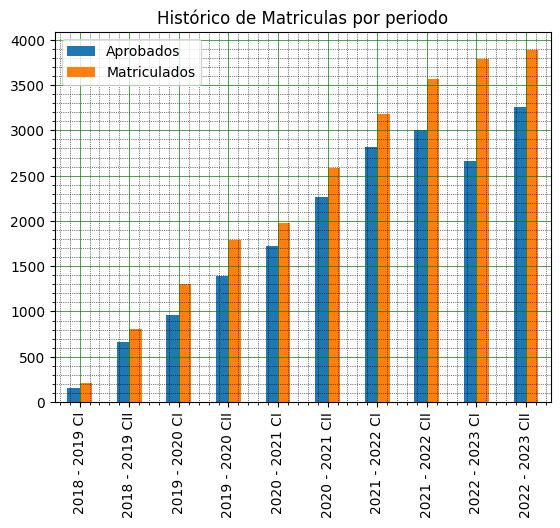

In [23]:
DataPeriodos=np.array(DataCalif["PERIODO"].unique()) # se busca las filas unicas en el campo "PERIODO"
c2=[] # Almacena la cantidad de estudiantes que tienen la condición de Aprobado
c3=[] # Almacena la cantidad total de estudiantes que hay en el PERIODO
DataPeriodos.sort() # ordena los periodos

for DataPeriodo in DataPeriodos: # Se preparan los datos que se mostrarán en la gráfica
  c2.append(DataCalif.apply(lambda x: x['ESTADOAP'] == 1 and x["PERIODO"] == DataPeriodo, axis=1).sum() )
  c3.append(DataCalif.apply(lambda x: x["PERIODO"] == DataPeriodo, axis=1).sum())

DataGrafi=pd.DataFrame({'Aprobados':c2, 'Matriculados':c3}, index=DataPeriodos)
DataGrafi.plot(kind='bar', title='Histórico de Matriculas por periodo')
plt.minorticks_on() # Para activar las grillas en el gráfico
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [24]:
# Se define las variables a analizar
# La variable "x" contiene los promedios de los estudiantes en el primer parcial
# La variable "y" contiene el estado final de aprobación del estudiante por materia

# Se escoje las columnas que se van a utilizar para el analisis predictivo 
# (variables independientes) y se asignan a la variable "x"
x= DataCalif.copy().iloc[:,1:10] 

# Se escoje la columna de resultados (variable dependiente)
# se asignan a la variable "y"
y= DataCalif["ESTADOAP"] 

 # Se divide la muestra en datos de entrenamiento y de prueba#, random_state=42) 
 # el atributo  random_state= es para que siempre se escoja los mismos datos
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.75)

# Verificamos que los datos de nuestro DataFrame son númericos
# x = x.astype(float)
# x.info()

<Axes: title={'center': 'Posibilidad de acierto  89.9 %'}>

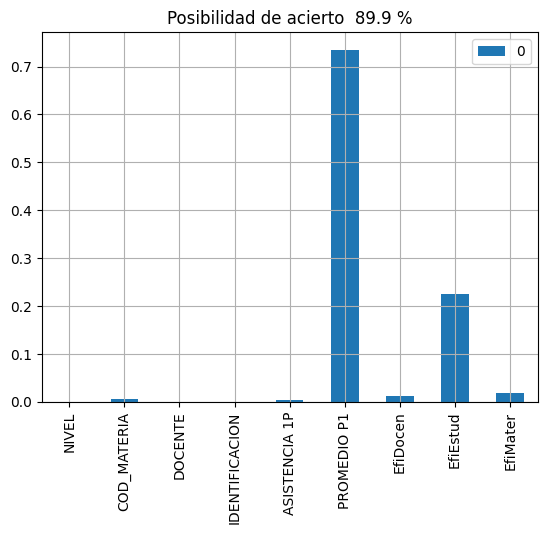

In [25]:
DataArbolDecis = tree.DecisionTreeClassifier(max_depth=5) # Generamos el arbol de desiciones con una profundidad de 5 niveles
DataArbolDecis = DataArbolDecis.fit(X_train, y_train)
yPredicha = DataArbolDecis.predict(X_test) # Ejecutamos la predicción de prueba
DataPreciPredi=accuracy_score(y_test, yPredicha) # accuray_score nos permite conocer el valor porcentual de aciertos en la predicción
DataMatriPredi=confusion_matrix(y_test, yPredicha,labels = (1, 0)) # La matriz de confusión nos enseña cuantas veces una clase fue asiganada correctamente
# precision_score muestra el porcentaje de posibilidad que la prediccion sea correcta
precision_score(y_test, yPredicha, pos_label = 1)
precision_score(y_test, yPredicha, pos_label = 0)
DataPrediPosib = pd.DataFrame(DataArbolDecis.feature_importances_, index = x.columns) # Obtenemos aquellas variables que son más importantes en nuestro arbol de decisión 
DataPrediPosib.plot(kind="bar",title=f"Posibilidad de acierto  {round(DataPreciPredi*100,2)} %",grid=True) # Grafica de los indices que son relevantes para la predicción

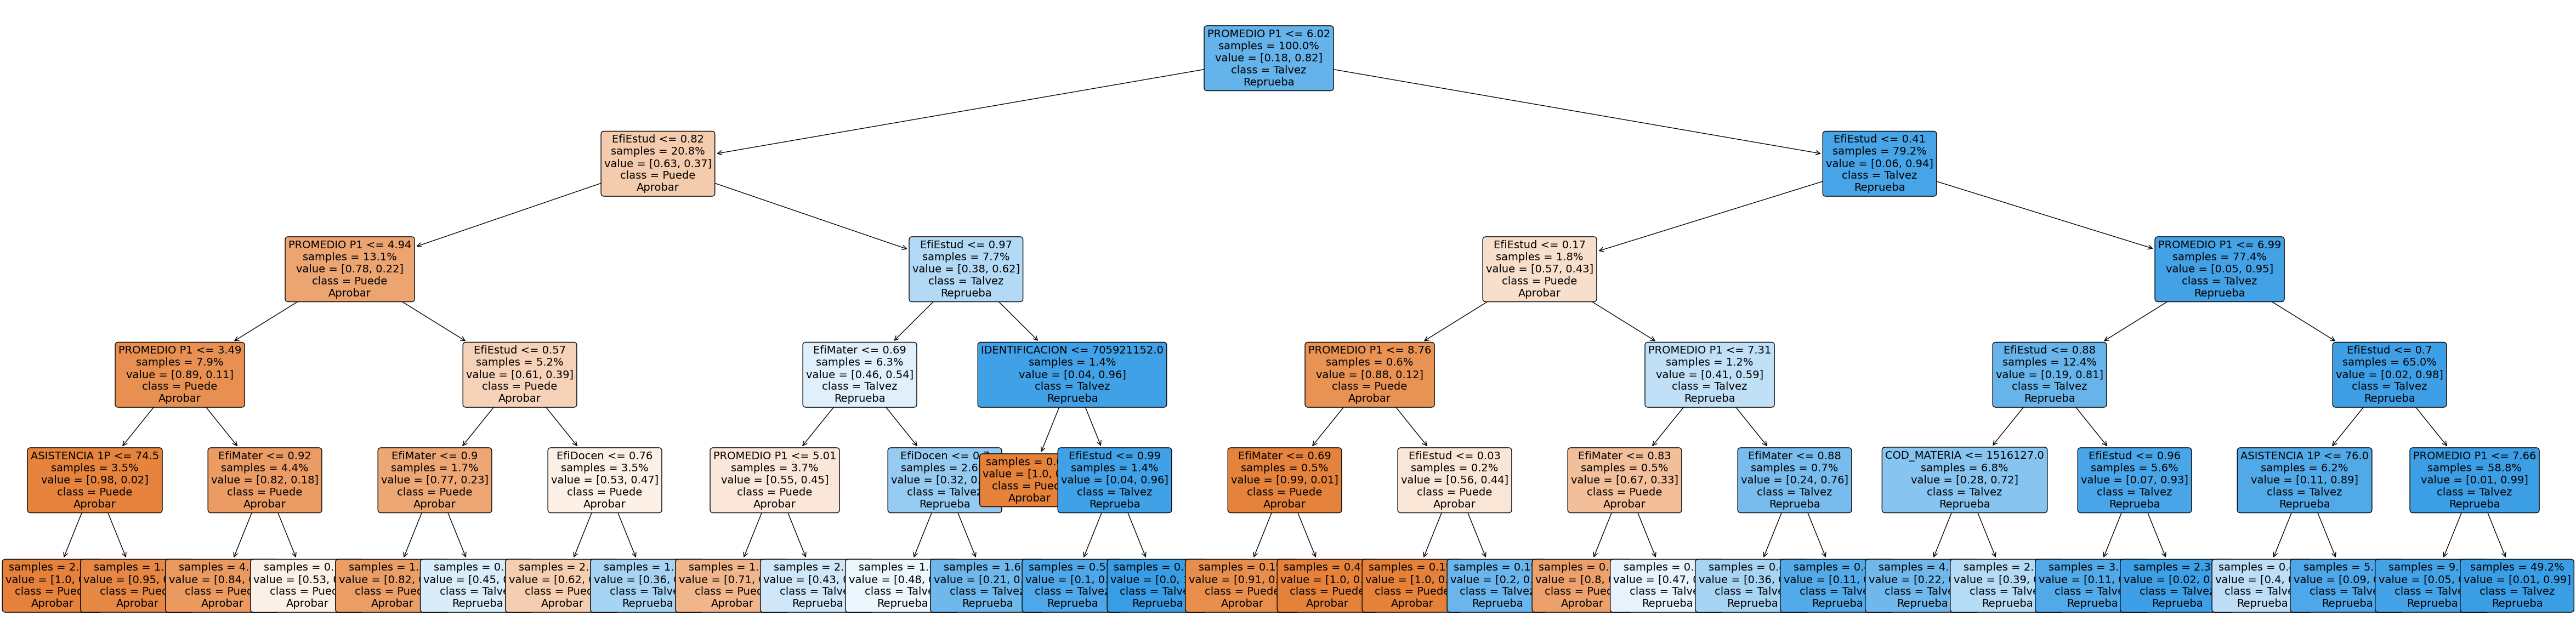

In [26]:
# Graficamos nuestro arbol de decision con una profundidad de 5 niveles 

DataGrafoArbol = plt.figure(figsize=(60,15)) 
_ = tree.plot_tree(DataArbolDecis,max_depth=5,impurity = False, rounded = True, proportion=True,
               feature_names = x.columns, precision=2,
               class_names = {0:"Puede\nAprobar",1:"Talvez\nReprueba"},
               filled = True,
               fontsize = 14)

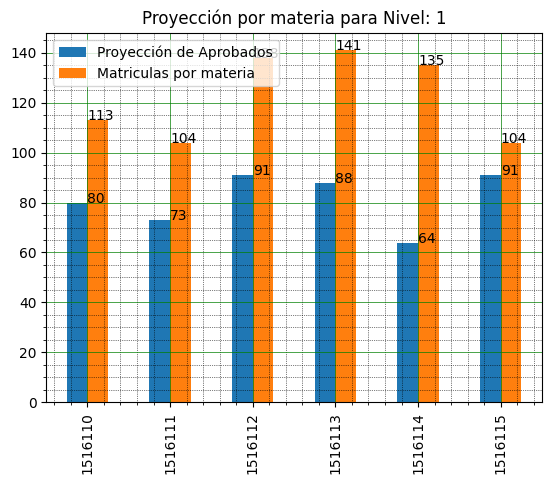

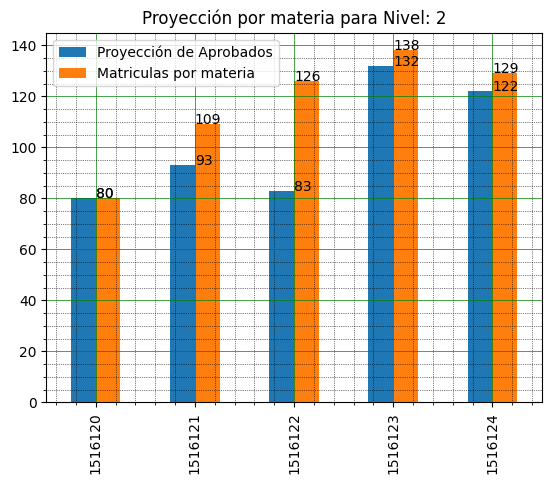

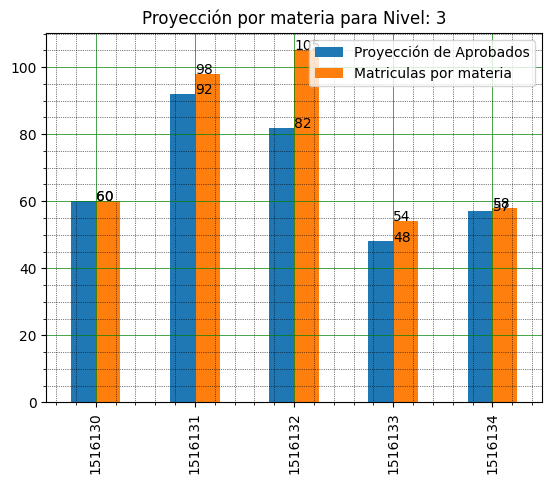

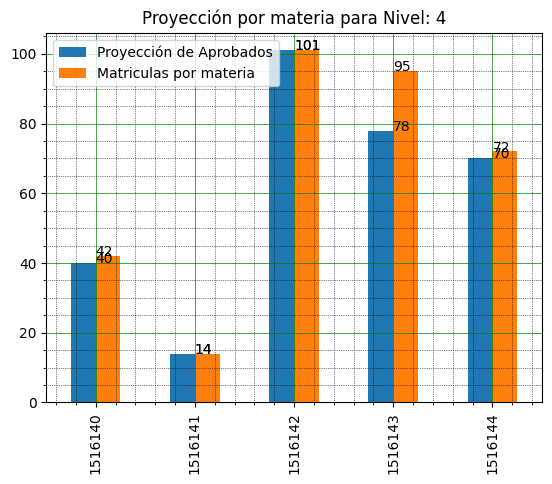

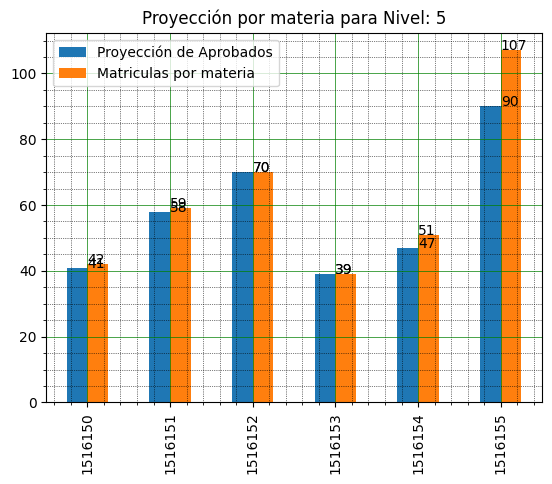

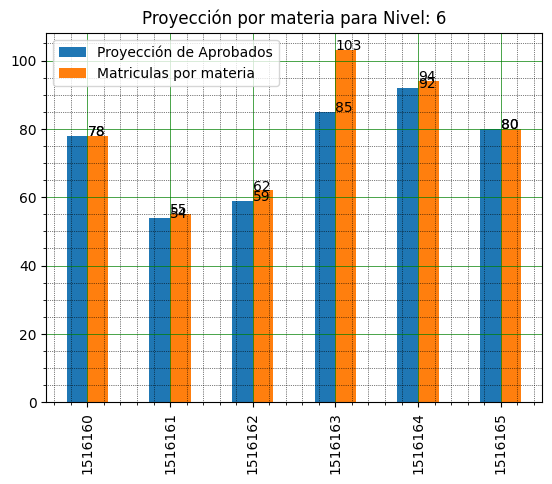

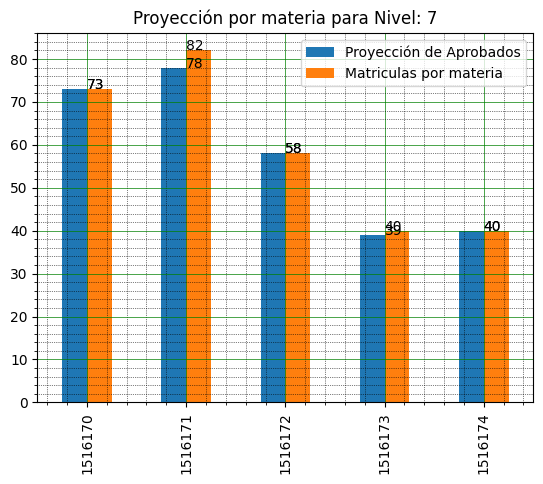

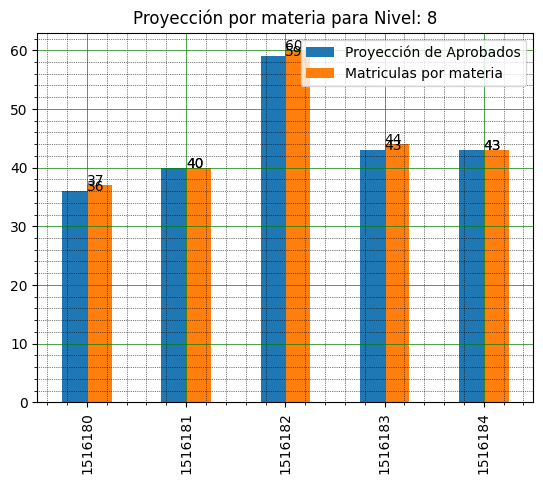

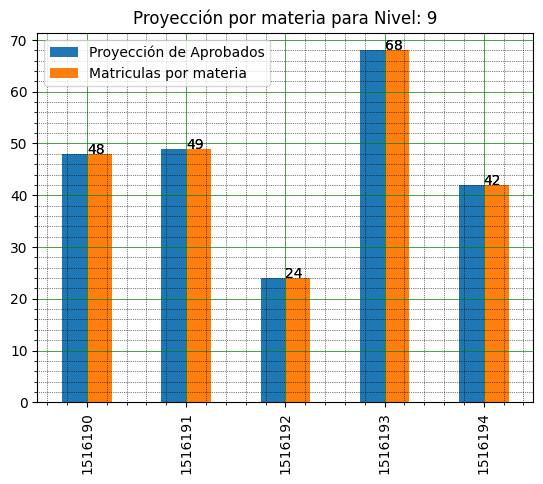

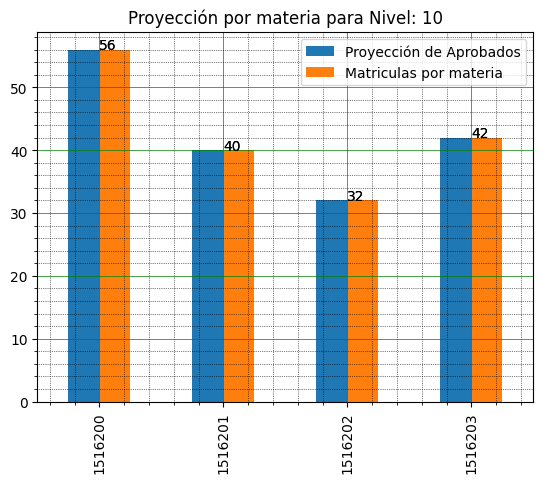

In [27]:
def add_value_label(x_list,y_list):
  for i in range(1, len(x_list)+1):
    #print((i,y_list[i-1],y_list[i-1]))
    plt.text(i-1.0,y_list[i-1],y_list[i-1])

# Se carga los datos para hacer las predicciones
ArchiDirec=os.getcwd()+"\\data\\" # Ruta de datos
Archivo=ArchiDirec + "datafin.xlsx"
ArchivoTest=ArchiDirec + "datatest.xlsx"
DataTest=pd.read_excel(ArchivoTest)

#print(DataTest.head())
xTest= DataTest.copy().iloc[:,1:10]
#print(X_test.head())

DataTest["ESTADOAP"] = DataArbolDecis.predict(xTest)
DataTest.to_csv(ArchiDirec + "proyeccion.csv",index=False)
DataTest.to_excel(ArchiDirec + "proyeccion.xlsx",index=False)


for i in range(10):
  DataPrediNiv=DataTest.loc[DataTest["NIVEL"] == (i+1)]
  DataMaterNiv=np.array(DataPrediNiv["COD_MATERIA"].unique()) # se busca las filas unicas en el campo "COD_MAT"
  c2=[] # Almacena la cantidad de estudiantes que tienen la predicción de Aprobado
  c3=[] # Almacena la cantidad de estudiantes registrados en la materia
  for DataGrafi01 in DataMaterNiv: # Se preparan los datos que se mostrarán en la gráfica
    c2.append(DataPrediNiv.apply(lambda x: x['ESTADOAP'] == 1 and x["COD_MATERIA"] == DataGrafi01, axis=1).sum() )
    c3.append(DataPrediNiv.apply(lambda x: x["COD_MATERIA"] == DataGrafi01, axis=1).sum() )

  DataGrafiTest=pd.DataFrame({'Proyección de Aprobados':c2, "Matriculas por materia":c3}, index=DataMaterNiv)
  DataGrafiTest.plot(kind='bar', title=f'Proyección por materia para Nivel: {i+1}')

  add_value_label(DataMaterNiv,c2)
  add_value_label(DataMaterNiv,c3)

  plt.minorticks_on() # Para activar las grillas en el gráfico
  plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
  plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.show()


# Modelado Random Forest

In [28]:


# Importar las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

ArchiDirec=os.getcwd()+"\\data\\" # Ruta de datos=carpeta actual\\data\\
Archivo=ArchiDirec + "datafin.xlsx" # Archivo con la información en formato xlsx
DataCalif = pd.read_excel(ArchiDirec + "datafin.xlsx")
# Cargar los datos de prueba desde un archivo CSV
data_test = pd.read_excel(ArchiDirec + "datatest.xlsx")

# El DataFrame usado es lo suficientemente grande y contiene suficientes opciones de aprobado o reprobado
# Localizamos los duplicados segun los campos que deben dar datos únicos, escogiendo la primera aparición de ser el caso
DataDuplicada = DataCalif.duplicated(subset = ["PERIODO","IDENTIFICACION","NIVEL","COD_MATERIA","DOCENTE"], keep = 'first')

# Buscamos y eliminamos las filas que tengan valores nulos en el campo "ASISTENCIA" y "PROM FINAL", y "PROM P1" ya que se necesita la información completa en estos campos
DataCalif.drop(DataCalif[(DataCalif["ASISTENCIA 1P"].isnull() )].index, inplace=True)
DataCalif.drop(DataCalif[(DataCalif["PROMEDIO P1"].isnull() )].index, inplace=True)


# Se escoje las columnas que se van a utilizar para el analisis predictivo 
# (variables independientes) y se asignan a la variable "x"
x= DataCalif.copy().iloc[:,1:10] 

# Se escoje la columna de resultados (variable dependiente)
# se asignan a la variable "y"
y= DataCalif["ESTADOAP"] 


 # Se divide la muestra en datos de entrenamiento y de prueba#, random_state=42) 
 # el atributo  random_state= es para que siempre se escoja los mismos datos
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.75)


# Crear un modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)  # Puedes ajustar el número de árboles (n_estimators) según tus necesidades

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo Random Forest: {accuracy:.2f}")

# Mostrar un informe de clasificación
report = classification_report(y_test, y_pred)
print("Informe de clasificación:\n", report)


Precisión del modelo Random Forest: 0.91
Informe de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.69      0.74      3176
           1       0.93      0.96      0.95     14145

    accuracy                           0.91     17321
   macro avg       0.86      0.83      0.84     17321
weighted avg       0.91      0.91      0.91     17321



In [29]:
# Importar las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

#x= DataCalif.copy().iloc[:,1:10] 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Escalar las características (opcional pero generalmente recomendado)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear un modelo de Regresión Logística
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo de Regresión Logística: {accuracy:.2f}")

# Mostrar un informe de clasificación
report = classification_report(y_test, y_pred)
print("Informe de clasificación:\n", report)


Precisión del modelo de Regresión Logística: 0.90
Informe de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.65      0.71       893
           1       0.92      0.96      0.94      3726

    accuracy                           0.90      4619
   macro avg       0.86      0.80      0.83      4619
weighted avg       0.89      0.90      0.89      4619

